<a href="https://colab.research.google.com/github/aserravalle/GAN-Generate-Fashion/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
import numpy as np
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import matplotlib.pyplot as plt
from math import sqrt

# Data
from keras.datasets import fashion_mnist
from keras.models import load_model

# Model Building
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten, BatchNormalization # Discriminator
from keras.layers import Reshape, Conv2DTranspose, Embedding, Concatenate, Activation # Generator
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

4423680/4422102 [==============================] - 0s 0us/step
y = 2 Pullover


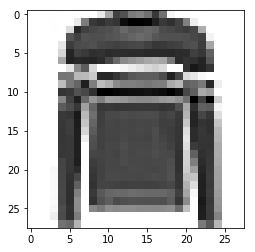

In [4]:
# Test that we have the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define the text labels
fashion_mnist_labels = ["T-shirt/top","Trouser", "Pullover", "Dress", "Coat",
                        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]   

img_index = 5                 #0 to 59,999
label_index = y_train[img_index] #Get labels
print ("y = " + str(label_index) + " " +(fashion_mnist_labels[label_index])) # print label
plt.imshow(x_train[img_index], cmap='gray_r') # Show image


# Building the Models

In [14]:
# Compiled discriminator model 
def Discriminator(in_shape=(28,28,1), n_classes=10):

    # Weights and input
    init = RandomNormal(stddev=0.02)
    test_img = Input(shape=in_shape)

    # Layers
    layers = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(test_img)
    layers = LeakyReLU(alpha=0.2)(layers)
    layers = Dropout(0.5)(layers)
    layers = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(layers)
    layers = BatchNormalization()(layers)
    layers = LeakyReLU(alpha=0.2)(layers)
    layers = Dropout(0.5)(layers)
    layers = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(layers)
    layers = BatchNormalization()(layers)
    layers = LeakyReLU(alpha=0.2)(layers)
    layers = Dropout(0.5)(layers)
    layers = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(layers)
    layers = BatchNormalization()(layers)
    layers = LeakyReLU(alpha=0.2)(layers)
    layers = Dropout(0.5)(layers)
    layers = Flatten()(layers)

    # Outputs
    real_fake = Dense(1, activation='sigmoid')(layers)
    clothing_class = Dense(n_classes, activation='softmax')(layers)

    # Define and Compile
    model = Model(test_img, [real_fake, clothing_class])
    model.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'],
                  optimizer = Adam(lr=0.0002, beta_1=0.5))
    
    return model

discriminator = Discriminator()
discriminator.summary()
#plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 14, 14, 32)   0           leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [15]:
def Generator(latent_dim = 100, n_classes = 10):
    init = RandomNormal(stddev=0.02)

    # Input = Image
    img = Input(shape=(latent_dim,))
    n_nodes = 384 * 7 * 7
    layers_img = Dense(n_nodes, kernel_initializer=init)(img)
    layers_img = Activation('relu')(layers_img)
    layers_img = Reshape((7, 7, 384))(layers_img)
    
    # Input = Label
    label = Input(shape=(1,))
    layers_lab = Embedding(n_classes, 50)(label)
    n_nodes = 7 * 7
    layers_lab = Dense(n_nodes, kernel_initializer=init)(layers_lab)
    layers_lab = Reshape((7, 7, 1))(layers_lab)
    
    # Merged layers
    merge = Concatenate()([layers_img, layers_lab])
    layers = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    layers = BatchNormalization()(layers)
    layers = Activation('relu')(layers)
    layers = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(layers)
    
    # Output
    generated_img = Activation('tanh')(layers)

    # Define Model
    model = Model([img, label], generated_img)
    return model

# define the size of the latent space
generator = Generator()
generator.summary()
#plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 18816)        1900416     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        500         input_8[0][0]                    
____________________________________________________________________________________________

In [16]:
def Combined(generator, discriminator):

    # Add the generated image to the Discriminator's hidden layers
    discriminator.trainable = False # This seems to cause warnings - what happens if I put it in the discriminator function?
    gen_img = discriminator(generator.output)  # Only one output layer

    # Define Model
    model = Model(generator.input, gen_img) # Model outputs the generated image

    model.compile(loss = ['binary_crossentropy', 'sparse_categorical_crossentropy'],
                  optimizer = Adam(lr=0.0002, beta_1=0.5))
    return model
GAN = Combined(generator, discriminator)
GAN.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 18816)        1900416     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        500         input_8[0][0]                    
____________________________________________________________________________________________

# Pipeline

In [0]:
# Load dataset
def get_data():

    (img_raw, Class), (_, _) = fashion_mnist.load_data() # Load image and category

    img = expand_dims(img_raw, axis=-1) # expand to 3d, e.g. add channels
    img = img.astype('float32')
    img = (img - 127.5) / 127.5 # scale from [0,255] to [-1,1]
    print(img.shape, Class.shape)
    return [img, Class]


In [0]:
# Sample images for the discriminator (evaluation)
def generate_real_samples(data, n_samples):

    images, labels = data # Get data
    ix = randint(0, images.shape[0], n_samples) # choose random index
    img_sample, label_sample = images[ix], labels[ix]	# select images and labels
    y = ones((n_samples, 1))	# label all these as real

    return [img_sample, label_sample], y

# Sample images for the generator (training)
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)	# generate points in the latent space
    z_input = x_input.reshape(n_samples, latent_dim)	# reshape into a batch of inputs for the network
    labels = randint(0, n_classes, n_samples)	# class for image we want to generate

    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)	# generate points in latent space
	images = generator.predict([z_input, labels_input])	# prediction output is a generated image
	y = zeros((n_samples, 1))	# label all these as fake
	return [images, labels_input], y

# Evaluation

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		plt.subplot(10, 10, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 

# Training

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=25, n_batch=32):

    # Training parameters
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    half_batch = int(n_batch / 2)

    # Training Loop
    for i in range(n_steps):

        # Train discriminator on real and generated data
            # Discriminator = Model(image, [real_fake, clothing class])
            # Generator = Model([image, label], generated_image)
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch) # Real sample
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real]) 
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # Generated sample
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])

        # Train GAN on discriminator's predictions
            # GAN = Model([latent_image, latent_label], generated_image)
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1)) # Label generated images as 1
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels]) # Learn how to predict
        
        # Print Losses
        print('>%d/%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, n_steps, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        
        # Evaluate and save model after every epoch
        if (i+1) % int(n_steps/10) == 0: # Will save 10 images with 100 generated garments each
            summarize_performance(i, g_model, latent_dim)

In [31]:
# Create models
discriminator = Discriminator()
generator = Generator()
gan_model = Combined(generator, discriminator)

# load image data
dataset = get_data()

# train model
train(generator, discriminator, gan_model, dataset, n_epochs=1)


(60000, 28, 28, 1) (60000,)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1/1875, dr[0.904,3.083], df[1.536,3.387], g[0.442,3.219]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2/1875, dr[0.570,3.319], df[1.032,3.030], g[0.899,3.262]
>3/1875, dr[0.736,2.324], df[1.025,3.721], g[0.835,3.292]
>4/1875, dr[0.736,3.046], df[0.891,3.179], g[0.731,3.201]
>5/1875, dr[0.760,3.740], df[0.850,2.852], g[1.075,3.075]
>6/1875, dr[0.747,2.484], df[0.765,3.518], g[1.151,2.560]
>7/1875, dr[0.418,3.170], df[0.728,2.899], g[1.263,2.916]
>8/1875, dr[0.571,2.921], df[0.641,3.089], g[1.232,3.346]
>9/1875, dr[0.633,2.281], df[0.695,3.361], g[1.383,4.081]
>10/1875, dr[0.595,2.466], df[0.808,2.867], g[1.257,3.406]
>11/1875, dr[0.753,2.810], df[0.625,3.842], g[1.187,2.933]
>12/1875, dr[0.762,3.011], df[0.799,2.654], g[1.372,3.171]
>13/1875, dr[0.332,2.463], df[0.631,2.422], g[1.582,3.417]
>14/1875, dr[0.627,2.503], df[0.590,3.515], g[1.463,3.235]
>15/1875, dr[0.511,2.359], df[0.661,3.162], g[1.432,3.076]
>16/1875, dr[0.603,2.390], df[0.703,3.140], g[1.637,2.977]
>17/1875, dr[0.957,2.158], df[0.586,3.036], g[1.373,3.342]
>18/1875, dr[0.515,3.123], df[0.548,2.382], g[1.225,3.231]
>19/1

# Function

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


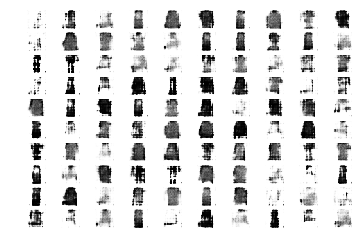

In [35]:
# Define the function that saves the generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
    
# Generate Images
def Generate(model_path, latent_dim = 100, n_rows = 10, n_class = 7):
    n_examples = n_rows**2
    latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
    
    model = load_model(model_path)
    X  = model.predict([latent_points, labels]) # Make prediction using NN
    X = (X + 1) / 2.0   # scale from [-1,1] to [0,1]
    save_plot(X, n_examples)   # plot the result

# Run
Generate('model_1800.h5')